<a href="https://colab.research.google.com/github/SalehMehrabani/PyTorch-Deep-Learning/blob/main/CNN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolution Neural Network
* PyTorch Convolutional Neural Network
* Food 101 dataset


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import ToTensor


In [2]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##Get Data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

    # Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...") 
  zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## Data Preparation and Data Exploration

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} image is {dirpath}")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 image is data/pizza_steak_sushi
There are 3 directories and 0 image is data/pizza_steak_sushi/train
There are 0 directories and 75 image is data/pizza_steak_sushi/train/steak
There are 0 directories and 78 image is data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 image is data/pizza_steak_sushi/train/sushi
There are 3 directories and 0 image is data/pizza_steak_sushi/test
There are 0 directories and 19 image is data/pizza_steak_sushi/test/steak
There are 0 directories and 25 image is data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 image is data/pizza_steak_sushi/test/sushi


In [6]:
#Setup training and testing paths
train_dir = image_path / "train"
test_dir= image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

##Visualizing image
* Get all of the image paths
* pick a random image path using Python's `random.choice()`
* Get the image class name using `pathlib.Path.parent.stem`
* Open image with Python **PIL** Library
* Show the image and print metadata 

Image path: data/pizza_steak_sushi/train/steak/214320.jpg
Image class: steak
Image heigh: 383 
Image width: 512


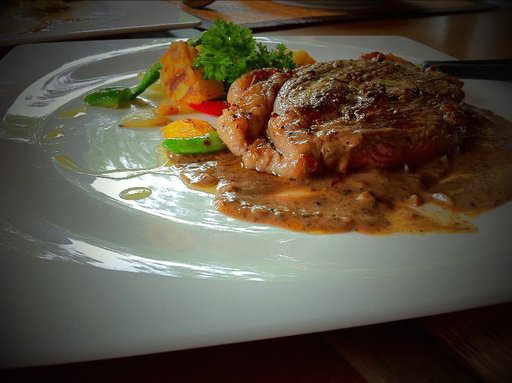

In [7]:
import random
from PIL import Image

# random.seed(42)

#Get all image path
image_path_list=list(image_path.glob("*/*/*.jpg"))
#Pick a random image path
random_image_path= random.choice(image_path_list)
#Get the image class form the path name(the image class is the name of the directory)
image_class= random_image_path.parent.stem
#Open image
img= Image.open(random_image_path)
#Print metadata
print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image heigh: {img.height} ")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 382.5, -0.5)

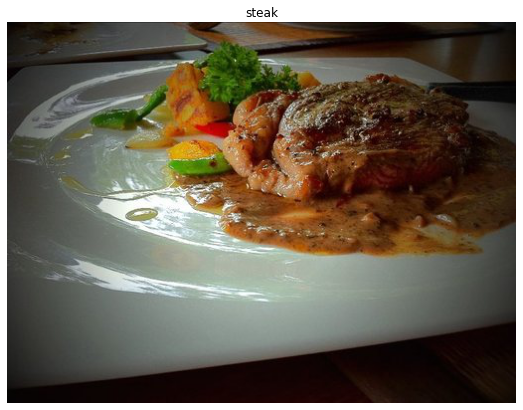

In [8]:
import numpy as np
import matplotlib.pyplot as plt

#Turn the image into the array
img_as_array= np.asarray(img)
#Plot the image 
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(image_class)
plt.axis(False)

##Transforming data into tensor

In [9]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [10]:
data_transforms= transforms.Compose([
    #Resize the image into 64x64
    transforms.Resize(size=(64,64)),
    #Flip the images randomly
    transforms.RandomHorizontalFlip(p=0.5),
    #Trun the imgae to tensor
    transforms.ToTensor()
])

In [11]:
data_transforms(img).shape

torch.Size([3, 64, 64])

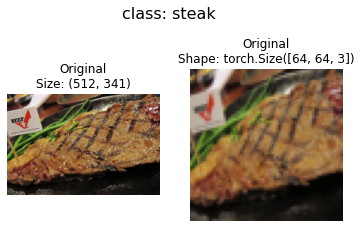

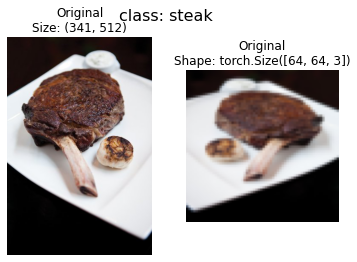

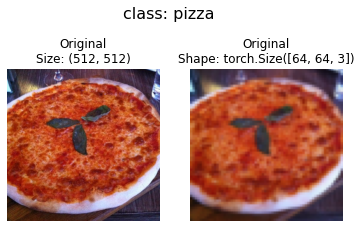

In [12]:
def plot_transformed_images(image_paths: list,
                            transform,
                            n=3,
                            seed=None):
  if seed:
    random.seed(seed)
  random_image_paths= random.sample(image_paths, k=n) 
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2) 
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #Transfom and plot target image
      transformed_image = transform(f).permute(1,2,0) #(C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Original\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths= image_path_list,
                        transform = data_transforms,
                        n=3, seed=42)  

##Option 1: Loading image data using `torchvision.datasets.ImageFolder`

In [13]:
from torchvision import datasets

train_data = datasets.ImageFolder(
    root= train_dir, 
    transform= data_transforms,
    target_transform= None
)
test_data= datasets.ImageFolder(
    root= test_dir,
    transform= data_transforms,
    target_transform= None
)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
#Get class names as list
class_names= train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
class_dict= train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
len(train_data), len(test_data)

(225, 75)

In [17]:
img, label = train_data[2][0], train_data[2][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.2314, 0.2314, 0.2275,  ..., 0.0431, 0.0392, 0.0392],
         [0.2196, 0.2235, 0.2196,  ..., 0.0392, 0.0392, 0.0392],
         [0.2118, 0.2118, 0.2078,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4039, 0.4863, 0.5373,  ..., 0.7961, 0.8078, 0.8118],
         [0.1608, 0.1961, 0.2902,  ..., 0.6392, 0.6157, 0.5176],
         [0.0784, 0.0902, 0.1216,  ..., 0.3647, 0.3333, 0.2863]],

        [[0.1922, 0.1922, 0.1922,  ..., 0.0392, 0.0353, 0.0353],
         [0.1843, 0.1843, 0.1804,  ..., 0.0353, 0.0353, 0.0353],
         [0.1765, 0.1725, 0.1765,  ..., 0.0392, 0.0353, 0.0353],
         ...,
         [0.3176, 0.4000, 0.4588,  ..., 0.5333, 0.5373, 0.5804],
         [0.1098, 0.1373, 0.2196,  ..., 0.3882, 0.3765, 0.2941],
         [0.0588, 0.0706, 0.0863,  ..., 0.1686, 0.1608, 0.1529]],

        [[0.2078, 0.2000, 0.1961,  ..., 0.0196, 0.0157, 0.0157],
         [0.1882, 0.1843, 0.1843,  ..., 0.0157, 0.0157, 0.0157],
         [0.1725, 0.1686, 0.1686,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


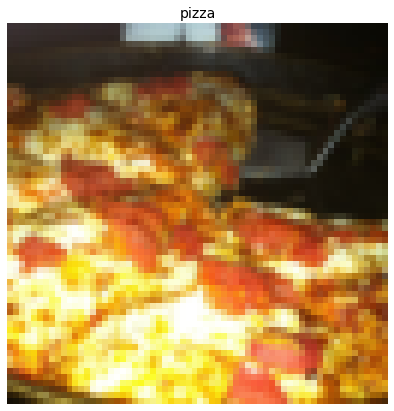

In [18]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [19]:
from torch.utils.data import DataLoader

BATCH_SIZE= 1

train_dataloader= DataLoader(
    dataset= train_data,
    batch_size= BATCH_SIZE,
    num_workers= 1,
    shuffle= True
)
test_dataloader= DataLoader(
    dataset= test_data,
    batch_size= BATCH_SIZE,
    num_workers= 1,
    shuffle= False
)

In [20]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Option 2: Loading image data with custom `Dataset`
1. Want to be able to load images from file
2. Want to able to get class name from the dataset
3. Want to able to get class name as dictionary from dataset



In [21]:
import os
import pathlib
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

Creating a helper function to get the class name
1. get the class names using `os.scandir()` to traverse a target directory (ideally the directory in standard image classification format)
2. Raise an error if the class name are'nt found
3. Turn the class name to list and dict and return them


In [22]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [23]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx 

In [24]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

###Create Custom Dataset
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory and transform function
3. Create several attributes: 
  * paths- paths of our image
  * transform - the Custom trasform function 
  * classes - a list of target classes
  * class_t0_idx - a dict of the target classes mapped to integer label
4. Create a function to `load_images()`, this function will opent an image
5. Overwrite the `__len__()` methods to return the lenght of our dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index.

In [26]:
#write a custome dataset
from torch.utils.data import Dataset

class ImageFolderCustome(Dataset):
  def __init__(self, 
               targ_dir: str,
               transform = None,):
    self.paths= list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform= transform
    self.classes, self.class_to_idx= find_classes(targ_dir)
  
  def load_image(self, index: int) -> Image.Image:
    image_path= self.paths[index]
    return Image.open(image_path)
  
  def __len__(self) -> int:
    return len(self.paths)
  
  def __getitem__(self, index: int) ->Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name= self.paths[index].parent.name
    class_idx= self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else: 
      return img, class_idx